In [49]:
# Refresh COVID collection if needed

import pickle
import json
import requests
from datetime import datetime
from time import sleep
from tqdm import tqdm
MAX_RETRIES = 5

# Use the bioRxiv API to obtain DOIs of papers pertaining to the COVID-19 pandemic


covid_collection_base = 'https://api.biorxiv.org/covid19/%d'

if not 'covid_preprints' in locals():
    covid_preprints = []
    while True:
        try:
            lengthInfo = json.loads(requests.get(
                covid_collection_base % 0).text)
            totalDocs = lengthInfo['messages'][0]['total']
            stepInterval = lengthInfo['messages'][0]['count']
            break
        except:
            pass
    for i in tqdm(range(0, totalDocs, stepInterval)):
        retries = 0
        while retries < MAX_RETRIES:
            try:
                response = json.loads(requests.get(
                    covid_collection_base % i).text)
                covid_preprints = covid_preprints + \
                    [{'server': datum['rel_site'], 'DOI': datum['rel_doi']}
                        for datum in response['collection']]
                break
            except:
                retries += 1
    print('\n%s COVID-19 SARS-CoV-2 DOIs found' % len(covid_preprints))
    pickle.dump(covid_preprints, open(datetime.strftime(
        datetime.today(), "%Y-%m-%d") + "_covid_preprints.p", 'wb'))


In [50]:
with open('data/2021-01-10_finalData.json') as f:
    dataWithPublished = json.load(f)


# Flat file creation

## Step 1 : Read in data and convert columns to correct formats

In [51]:
import pandas as pd
import numpy as np
import re
from datetime import datetime


def lowerAndRemoveReturns(string):
    if pd.isna(string):
        return
    return re.sub(r'\r|\n', ' ', string.lower())


dateColumns = [
    'date',
    'pub_date',
    'crossref_pub_date',
    'pub_date_received',
    'pub_date_accepted',
    'pub_date_entrez',
    'pub_date_pubmed',
    'pub_date_medline',
    'pub_date_revised',
    'pub_date_pmc-release'
]

integerColumns = [
    'version',
    'pmid',
    'pp_num_authors',
    'pub_num_authors',
    'pp_num_citations',
    'pub_num_citations'
]

stringColumns = [
    'published',
    'pub_date_type',
    'abstract',
    'scraped_abstract',
    'title',
    'pub_abstract',
    'pub_title',
    'pub_journal_name',
    'category',
    'server',
    'authors',
    'author_corresponding',
    'author_corresponding_institution'
]

columnsToDrop = [
    'altmetricData',
    'engagement'
]

df = pd.DataFrame.from_records(dataWithPublished)

df[dateColumns + stringColumns] = df[dateColumns +
                                     stringColumns].replace({np.nan: None})

df[stringColumns + ['doi']] = df[stringColumns + ['doi']].astype("string")
df[integerColumns] = df[integerColumns].astype(float).astype('Int64')
df[dateColumns] = df[dateColumns].apply(lambda x: pd.to_datetime(x).dt.date)
df['scraped_abstract'] = df['scraped_abstract'].str.replace(
    re.compile(r"^[Aa][Bb][Ss][Tt][Rr][Aa][Cc][Tt]"), "")
df['scraped_abstract'] = df['scraped_abstract'].str.replace(
    re.compile(r"^[Ss][Uu][Mm][Mm][Aa][Rr][Yy]"), "")
df[stringColumns] = df[stringColumns].applymap(lowerAndRemoveReturns)


# Extract out engagement metrics
df['Abstract Views'] = df.engagement.apply(lambda x: x['Abstract'] if (
    not pd.isna(x) and 'Abstract' in x.keys()) else None)
df['PDF Downloads'] = df.engagement.apply(
    lambda x: x['Pdf'] if (not pd.isna(x) and 'Pdf' in x.keys()) else None)

# Extract article types
df['trial_yn'] = df.pm_pub_types.apply(lambda x: True if isinstance(x, list) and len(
    [i for i in x if "Trial" in i and "Protocol" not in i]) > 0 else False)
df['review_yn'] = df.pm_pub_types.apply(lambda x: True if isinstance(x, list) and len(
    [i for i in x if "Review" in i and "Systematic Review" not in i]) > 0 else False)

# Remove errors
errors = pd.read_csv("known-errors.csv")
pp_errors = errors[errors.type == 'preprint']['doi'].unique()
df = df[~df.doi.isin(pp_errors)]

df.drop(columnsToDrop, inplace=True, axis=1)


## Step 2: Filter out data irrelevant to primary analysis

In [52]:
# Only keep version 1s
df = df[df.version == 1]

# Only keep preprints published ahead of their peer-reviewed publication
df = df[df.date < df.crossref_pub_date]

# KEEPING THIS UNTIL WE DETERMINE WHY THERE ARE MULTIPLE version 1s FOR SOME PREPRINTS (e.g. 10.1101/703660)
df.drop_duplicates(subset=['doi'], inplace=True, ignore_index=True)


## Step 3: Assign rows to study cohorts

In [53]:
from datetime import date

# January 19th, 2020 is the date that the first SARS-CoV-2 preprint was deposited on either bioRxiv or medRxiv
first_preprint_SARS_CoV_2_article = date(2020, 1, 19)

# This date defines the historical extent of the lookback period for the 'preceding control period' articles from before the pandemic
left_date_study_period = first_preprint_SARS_CoV_2_article - \
    (date(2020, 12, 21) - first_preprint_SARS_CoV_2_article)

covid_preprint_dois = [x['DOI'] for x in covid_preprints]


def cohort_criteria(row):
    if row['date'] < left_date_study_period:
        return None  # Don't include if before the prior control period
    if pd.isna(row['crossref_pub_date']):
        return None  # Don't include if PubMed did not have data on the published DOI
    if row['date'] < first_preprint_SARS_CoV_2_article and row['crossref_pub_date'] < first_preprint_SARS_CoV_2_article:
        # Articles with both v1 of preprint AND published article appearing within the control period
        return 'preceding control period'
    if row['doi'] in covid_preprint_dois:
        # Articles with both v1 of preprint AND published article appearing within the pandemic period
        return 'intra-pandemic SARS-CoV-2'
    if row['doi'] not in covid_preprint_dois and row['date'] > first_preprint_SARS_CoV_2_article:
        # Articles with both v1 of preprint AND published article appearing within the pandemic period
        return 'intra-pandemic non-SARS-CoV-2'
    return None


df['cohort'] = df.apply(cohort_criteria, axis=1)


In [54]:
# Count how many have a defined journal name

len(df[
    ~pd.isna(df['pub_journal_name']) &
    ~pd.isna(df['cohort'])
])


7547

## Step 4: Only include in analysis those journals that publish both COVID-19 and non-COVID-19 articles

In [55]:
journals_of_interest = list(set(
    df[df.cohort == 'intra-pandemic SARS-CoV-2']['pub_journal_name'].tolist()
) & set(
    df[df.cohort == 'intra-pandemic non-SARS-CoV-2']['pub_journal_name'].tolist()
) & set(
    df[df.cohort == 'preceding control period']['pub_journal_name'].tolist()
))

df = df[df.pub_journal_name.isin(journals_of_interest)]


len(df[~pd.isna(df.cohort)])


7547

## Step 5: Only include in analysis those rows for which titles, abstracts, and cohort data are all non-null

In [56]:
df.replace("", np.NaN, inplace=True)

# Only include in analysis those rows for which ...
columnsThatNeedToBeCompletelyDefined = [
    'scraped_abstract',  # ... preprint abstract is defined AND ...
    'pub_abstract', # ... abstract found on PubMed for the published version AND ...
    'pub_journal_name',
    'cohort'  # ... row belongs to one of the three study cohorts ...
]

df = df[~df[columnsThatNeedToBeCompletelyDefined].isna().any(1)]


/Users/joshg/opt/anaconda3/lib/python3.7/site-packages/pandas/core/missing.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x
/Users/joshg/opt/anaconda3/lib/python3.7/site-packages/pandas/core/missing.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


In [57]:
# Size of total

print("%s published pairs" % len(df))

preprint_altmetric_search_list = '\n'.join(x.doi for x in df.iloc)
published_altmetric_search_list = '\n'.join(x.published for x in df.iloc)

todays_date = datetime.strftime(datetime.today(), "%Y-%m-%d")

with open(todays_date + '_preprints-altmetric-search.txt', 'w') as f:
    f.write(preprint_altmetric_search_list)
with open(todays_date + '_published-altmetric-search.txt', 'w') as f:
    f.write(published_altmetric_search_list)


7546 published pairs


## Step 6: Remove stop words, punctuation, and lemmatize abstract text

In [58]:
import spacy
#import sys
#!{sys.executable} -m spacy download en
import nltk
from nltk import word_tokenize
from unidecode import unidecode
import string


def spacyLemmatize(abstract, model):
    doc = model(abstract)
    return " ".join([token.lemma_ for token in doc])


def removeStopWordsPunctuation(abstract, stopset):
    abstract = abstract.translate(str.maketrans('', '', string.punctuation))
    abstract = " ".join(
        [i for i in word_tokenize(abstract) if i not in stopset])
    abstract = unidecode(abstract)
    return abstract


nlp = spacy.load('en', disable=['parser', 'ner'])
stopset = nlp.Defaults.stop_words.union(list(string.punctuation))

columnsToRemoveStopWords = [
    'scraped_abstract',
    'pub_abstract'
]

outputColumns = [
    'scraped_abstract_lemmatized',
    'pub_abstract_lemmatized'
]

df[outputColumns] = df[columnsToRemoveStopWords].applymap(
    lambda x: removeStopWordsPunctuation(x, stopset))
df[outputColumns] = df[outputColumns].applymap(
    lambda x: spacyLemmatize(x, nlp))


## Step 7: Construct term frequency vectors between terms found in both documents of a pair; compute the cosine similarity of resulting vectors

In [59]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.feature_extraction.text import CountVectorizer


def get_cosine_diff(*strs):
    vectors = [t for t in get_vectors(*strs)]
    return cosine_distances(vectors)


def get_vectors(*strs):
    text = [t for t in strs]
    vectorizer = CountVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()


df['abstract_diff_cosine_tf'] = df.apply(lambda x: get_cosine_diff(
    x['scraped_abstract_lemmatized'], x['pub_abstract_lemmatized'])[1][0], axis=1)


In [60]:
# Save flat file as pipe-delimited
import csv

todays_date = datetime.strftime(datetime.today(), "%Y-%m-%d")
df.to_csv(todays_date + '_flat-file_v1s.psv', sep='|', quoting=csv.QUOTE_NONE, quotechar="", escapechar="\\", index=False)


# Get results!

In [61]:
# Load in data
import pandas as pd
import numpy as np
import csv

df = pd.read_csv('2021-01-12_flat-file_v1s.psv', sep = '|', quoting=csv.QUOTE_NONE, quotechar="", escapechar="\\")

dateColumns = [
    'date',
    'pub_date',
    'crossref_pub_date',
    'pub_date_received',
    'pub_date_accepted',
    'pub_date_entrez',
    'pub_date_pubmed',
    'pub_date_medline',
    'pub_date_revised',
    'pub_date_pmc-release'
]

integerColumns = [
    'version',
    'pmid',
    'pp_num_authors',
    'pub_num_authors',
    'pp_num_citations',
    'pub_num_citations'
]

stringColumns = [
    'published',
    'pub_date_type',
    'abstract',
    'scraped_abstract',
    'title',
    'pub_abstract',
    'pub_title',
    'pub_journal_name',
    'category',
    'server',
    'authors',
    'author_corresponding',
    'author_corresponding_institution'
]

df[dateColumns + stringColumns] = df[dateColumns +
                                     stringColumns].replace({np.nan: None})

df[stringColumns + ['doi']] = df[stringColumns + ['doi']].astype("string")
df[integerColumns] = df[integerColumns].astype(float).astype('Int64')
df[dateColumns] = df[dateColumns].apply(lambda x: pd.to_datetime(x).dt.date)

### Dimensions citation data

In [62]:
from datetime import date, timedelta, datetime, time
date_citation_data_was_collected = date(2020, 12, 29)
ninetyDaysBeforeDataCollection = date_citation_data_was_collected + \
    timedelta(days=-91)  # Add one day to account for Dimensions citation updates

pp_cit_90Day_df = df[df.date <= ninetyDaysBeforeDataCollection]
pub_cit_90Day_df = df[df.crossref_pub_date <= ninetyDaysBeforeDataCollection]

display(pp_cit_90Day_df[~pd.isna(pp_cit_90Day_df.pp_num_citations)].groupby(
    'cohort')['pp_num_citations'].quantile([0.5, 0.25, 0.75]))

display(pub_cit_90Day_df[~pd.isna(pub_cit_90Day_df.pub_num_citations)].groupby(
    'cohort')['pub_num_citations'].quantile([0.5, 0.25, 0.75]))


cohort                             
intra-pandemic SARS-CoV-2      0.50    2.0
                               0.25    0.0
                               0.75    6.0
intra-pandemic non-SARS-CoV-2  0.50    0.0
                               0.25    0.0
                               0.75    0.0
preceding control period       0.50    0.0
                               0.25    0.0
                               0.75    0.0
Name: pp_num_citations, dtype: float64

cohort                             
intra-pandemic SARS-CoV-2      0.50     4.0
                               0.25     1.0
                               0.75    12.0
intra-pandemic non-SARS-CoV-2  0.50     0.0
                               0.25     0.0
                               0.75     1.0
preceding control period       0.50     0.0
                               0.25     0.0
                               0.75     1.0
Name: pub_num_citations, dtype: float64

In [63]:
print("Number of pairs used for analysis: ")

print("Preprint counts: \n%s" % pp_cit_90Day_df[~pd.isna(
    pp_cit_90Day_df.pp_num_citations)].groupby('cohort').size())

print("Preprint fraction: \n%s" % pp_cit_90Day_df[~pd.isna(pp_cit_90Day_df.pp_num_citations)].groupby('cohort').size().divide(
    df.groupby('cohort').size()
))

print("Published counts: \n%s" % pub_cit_90Day_df[~pd.isna(
    pub_cit_90Day_df.pub_num_citations)].groupby('cohort').size())

print("Published fraction: \n%s" % pub_cit_90Day_df[~pd.isna(pub_cit_90Day_df.pub_num_citations)].groupby('cohort').size().divide(
    df.groupby('cohort').size()
))


Number of pairs used for analysis: 
Preprint counts: 
cohort
intra-pandemic SARS-CoV-2        1157
intra-pandemic non-SARS-CoV-2    3571
preceding control period         2765
dtype: int64
Preprint fraction: 
cohort
intra-pandemic SARS-CoV-2        0.983008
intra-pandemic non-SARS-CoV-2    0.991119
preceding control period         0.999638
dtype: float64
Published counts: 
cohort
intra-pandemic SARS-CoV-2         786
intra-pandemic non-SARS-CoV-2    2230
preceding control period         2766
dtype: int64
Published fraction: 
cohort
intra-pandemic SARS-CoV-2        0.667799
intra-pandemic non-SARS-CoV-2    0.618929
preceding control period         1.000000
dtype: float64


In [64]:
from scipy.stats import chisquare, median_test

func = median_test

metric = 'pub_num_citations'

control = pub_cit_90Day_df[~pd.isna(pub_cit_90Day_df[metric]) & (
    pub_cit_90Day_df.cohort == 'preceding control period')][metric].tolist()
non_SARS = pub_cit_90Day_df[~pd.isna(pub_cit_90Day_df[metric]) & (
    pub_cit_90Day_df.cohort == 'intra-pandemic non-SARS-CoV-2')][metric].tolist()
SARS = pub_cit_90Day_df[~pd.isna(pub_cit_90Day_df[metric]) & (
    pub_cit_90Day_df.cohort == 'intra-pandemic SARS-CoV-2')][metric].tolist()

print("\n%s on %s:\n" % (func.__name__, metric))
print("control vs. non-SARS (p): \t%s" % func(control, non_SARS)[1])
print("SARS vs. non-SARS (p): \t\t%s" % func(SARS, non_SARS)[1])
print("control vs. SARS (p): \t\t%s" % func(control, SARS)[1])

metric = 'pp_num_citations'

control = pp_cit_90Day_df[~pd.isna(pp_cit_90Day_df[metric]) & (
    pp_cit_90Day_df.cohort == 'preceding control period')][metric].tolist()
non_SARS = pp_cit_90Day_df[~pd.isna(pp_cit_90Day_df[metric]) & (
    pp_cit_90Day_df.cohort == 'intra-pandemic non-SARS-CoV-2')][metric].tolist()
SARS = pp_cit_90Day_df[~pd.isna(pp_cit_90Day_df[metric]) & (
    pp_cit_90Day_df.cohort == 'intra-pandemic SARS-CoV-2')][metric].tolist()

print("\n%s on %s:\n" % (func.__name__, metric))
print("control vs. non-SARS (p): \t%s" % func(control, non_SARS)[1])
print("SARS vs. non-SARS (p): \t\t%s" % func(SARS, non_SARS)[1])
print("control vs. SARS (p): \t\t%s" % func(control, SARS)[1])



median_test on pub_num_citations:

control vs. non-SARS (p): 	0.9395708362659542
SARS vs. non-SARS (p): 		6.688647631411943e-176
control vs. SARS (p): 		2.218719738149126e-186

median_test on pp_num_citations:

control vs. non-SARS (p): 	0.49064162859577287
SARS vs. non-SARS (p): 		1.7955830680787623e-232
control vs. SARS (p): 		1.5647868219885122e-216


### Number per cohort

In [65]:
print("# per cohort: ")
df.groupby('cohort').size()


# per cohort: 


cohort
intra-pandemic SARS-CoV-2        1177
intra-pandemic non-SARS-CoV-2    3603
preceding control period         2766
dtype: int64

In [66]:
# Median upload date of preprints in the COVID-19 cohort

df[df.cohort == 'intra-pandemic SARS-CoV-2']['date'].astype('datetime64[ns]').quantile(.5)

Timestamp('2020-05-17 00:00:00')

### Abstract difference by cohort

In [67]:
print("Abstract difference by cohort:")

display(
    df.groupby('cohort')['abstract_diff_cosine_tf'].quantile([0.5, 0.25, 0.75])
)
display(
    df.groupby('cohort')['abstract_diff_cosine_tf'].quantile([0.5, 0.25, 0.75]).divide(
        df[df.cohort == 'preceding control period']['abstract_diff_cosine_tf'].quantile([0.5]).item())
)


Abstract difference by cohort:


cohort                             
intra-pandemic SARS-CoV-2      0.50    0.111507
                               0.25    0.041770
                               0.75    0.222490
intra-pandemic non-SARS-CoV-2  0.50    0.045343
                               0.25    0.013356
                               0.75    0.111286
preceding control period       0.50    0.045944
                               0.25    0.011620
                               0.75    0.106666
Name: abstract_diff_cosine_tf, dtype: float64

cohort                             
intra-pandemic SARS-CoV-2      0.50    2.427020
                               0.25    0.909151
                               0.75    4.842635
intra-pandemic non-SARS-CoV-2  0.50    0.986925
                               0.25    0.290698
                               0.75    2.422214
preceding control period       0.50    1.000000
                               0.25    0.252918
                               0.75    2.321653
Name: abstract_diff_cosine_tf, dtype: float64

### Word counts

In [68]:
countWordColumns = [
    'scraped_abstract',
    'pub_abstract',
    'scraped_abstract_lemmatized',
    'pub_abstract_lemmatized'
]

print("Preprint and published abstract word count by cohort: ")

df[[col + '_wc' for col in countWordColumns]] = df[countWordColumns].applymap(lambda x: len(x.split())).astype('Int64')
df[['cohort', 'scraped_abstract_wc', 'pub_abstract_wc', 'scraped_abstract_lemmatized_wc', 'pub_abstract_lemmatized_wc']].groupby('cohort').quantile([0.5, 0.25, 0.75], interpolation='nearest')


Preprint and published abstract word count by cohort: 


scraped_abstract_wc  pub_abstract_wc  \
cohort                                                                     
intra-pandemic SARS-CoV-2     0.50                  210              203   
                              0.25                  157              151   
                              0.75                  264              254   
intra-pandemic non-SARS-CoV-2 0.50                  203              198   
                              0.25                  156              151   
                              0.75                  262              247   
preceding control period      0.50                  208              199   
                              0.25                  156              152   
                              0.75                  273              250   

                                    scraped_abstract_lemmatized_wc  \
cohort                                                               
intra-pandemic SARS-CoV-2     0.50                             129   
                              0.25                              97   
                              0.75                             168   
intra-pandemic non-SARS-CoV-2 0.50                             129   
                              0.25                             101   
                              0.75                             165   
preceding control period      0.50                             130   
                              0.25                             101   
                              0.75                             169   

                                    pub_abstract_lemmatized_wc  
cohort                                                          
intra-pandemic SARS-CoV-2     0.50                         124  
                              0.25                          96  
                              0.75                         162  
intra-pandemic non-SARS-CoV-2 0.50                         121  
                              0.25                          97  
                              0.75                         153  
preceding control period      0.50                         122  
                              0.25                          98  
                              0.75                         154

In [69]:
from scipy.stats import median_test

metric_1 = 'scraped_abstract_wc'
metric_2 = 'pub_abstract_wc'
cohort_of_interest = 'intra-pandemic SARS-CoV-2'

pp = df[df.cohort == cohort_of_interest][metric_1].tolist()
pub = df[df.cohort == cohort_of_interest][metric_2].tolist()

median_test(pp, pub)[1]


0.1079016621890152

### Breakdown by preprint server (bioRxiv/medRxiv)

In [70]:
print("Preprints breakdown by server (No.):")
display(df.groupby(['cohort', 'server']).size())
print("Preprints breakdown by server (%):")
display(df.groupby(['cohort', 'server']).size().groupby(
    level=0).apply(lambda x: 100 * x / float(x.sum())))


Preprints breakdown by server (No.):


cohort                         server 
intra-pandemic SARS-CoV-2      biorxiv     482
                               medrxiv     695
intra-pandemic non-SARS-CoV-2  biorxiv    3380
                               medrxiv     223
preceding control period       biorxiv    2724
                               medrxiv      42
dtype: int64

Preprints breakdown by server (%):


cohort                         server 
intra-pandemic SARS-CoV-2      biorxiv    40.951572
                               medrxiv    59.048428
intra-pandemic non-SARS-CoV-2  biorxiv    93.810713
                               medrxiv     6.189287
preceding control period       biorxiv    98.481562
                               medrxiv     1.518438
dtype: float64

### Number of preprint versions by cohort

In [10]:
version_no = df[['doi', 'cohort']].copy()

total_data = pd.DataFrame.from_records(dataWithPublished)

total_data.drop_duplicates(
    subset=['doi', 'version'], inplace=True, ignore_index=True)

version_info = version_no.merge(total_data, how="right", on='doi')

data = []

for doi in version_no['doi'].unique():
    data += [{"DOI": doi, "cohort": version_no.loc[version_no.doi == doi]['cohort'].iloc[0],
              "num_versions": len(total_data.loc[total_data.doi == doi]['version'].tolist())}]


NameError: name 'dataWithPublished' is not defined

In [22]:
print("# of preprint versions by cohort:")

a = pd.DataFrame.from_records(data)
display(a.groupby('cohort')['num_versions'].quantile(
    [0.25, 0.5, 0.75], interpolation='nearest'))
print("# of preprint articles with multiple versions by cohort: ")
display(a[a.num_versions > 1].groupby('cohort').size())
print("% of preprint articles with multiple versions by cohort: ")
display(a[a.num_versions > 1].groupby('cohort').size().divide(
    df.groupby('cohort').size()
))


# of preprint versions by cohort:
# of preprint articles with multiple versions by cohort: 
% of preprint articles with multiple versions by cohort: 


cohort                             
intra-pandemic SARS-CoV-2      0.25    1
                               0.50    1
                               0.75    2
intra-pandemic non-SARS-CoV-2  0.25    1
                               0.50    1
                               0.75    1
preceding control period       0.25    1
                               0.50    1
                               0.75    1
Name: num_versions, dtype: int64

cohort
intra-pandemic SARS-CoV-2        389
intra-pandemic non-SARS-CoV-2    682
preceding control period         435
dtype: int64

cohort
intra-pandemic SARS-CoV-2        0.329661
intra-pandemic non-SARS-CoV-2    0.189129
preceding control period         0.157267
dtype: float64

### Days from version 1 preprint upload to publication

In [71]:
df['days_to_publication'] = df.apply(lambda x: (
    x['crossref_pub_date'] - x['date']).days, axis=1)
print("Days to publication by cohort:\n")
df.groupby('cohort')['days_to_publication'].quantile(
    [0.5, 0.25, 0.75], interpolation='nearest')


Days to publication by cohort:



cohort                             
intra-pandemic SARS-CoV-2      0.50     79
                               0.25     49
                               0.75    122
intra-pandemic non-SARS-CoV-2  0.50    125
                               0.25     83
                               0.75    177
preceding control period       0.50    124
                               0.25     81
                               0.75    171
Name: days_to_publication, dtype: int64

### Author changes

In [72]:
df['author_change'] = df['pub_num_authors'] - df['pp_num_authors']

display(
    df[df.author_change != 0].groupby('cohort').size()
)

display(
    df[df.author_change == 0].groupby('cohort').size()
)

display(
    df[df.author_change != 0].groupby('cohort').size().divide(
        df.groupby('cohort').size()  # Divide by cohort N to get %
    )
)

display(
    df[df.author_change == 0].groupby('cohort').size().divide(
        df.groupby('cohort').size()  # Divide by cohort N to get %
    )
)


cohort
intra-pandemic SARS-CoV-2        324
intra-pandemic non-SARS-CoV-2    445
preceding control period         339
dtype: int64

cohort
intra-pandemic SARS-CoV-2         853
intra-pandemic non-SARS-CoV-2    3158
preceding control period         2427
dtype: int64

cohort
intra-pandemic SARS-CoV-2        0.275276
intra-pandemic non-SARS-CoV-2    0.123508
preceding control period         0.122560
dtype: float64

cohort
intra-pandemic SARS-CoV-2        0.724724
intra-pandemic non-SARS-CoV-2    0.876492
preceding control period         0.877440
dtype: float64

### Calculate statistics

#### Median tests

In [73]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7546 entries, 0 to 7545
Data columns (total 53 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   doi                               7546 non-null   string 
 1   title                             7546 non-null   string 
 2   authors                           7546 non-null   string 
 3   author_corresponding              7546 non-null   string 
 4   author_corresponding_institution  7546 non-null   string 
 5   date                              7546 non-null   object 
 6   version                           7546 non-null   Int64  
 7   type                              7542 non-null   object 
 8   license                           7540 non-null   object 
 9   category                          7546 non-null   string 
 10  abstract                          7546 non-null   string 
 11  published                         7546 non-null   string 
 12  server

In [74]:
from scipy.stats import median_test

data_frame = df
# data_frame = test_pub_df
# data_frame = test_pp_df

func = median_test

# metric = 'Tweet'
# metric = 'abstract_diff_cosine_tf'
# metric = 'scraped_abstract_lemmatized_wc'
# metric = 'pub_abstract_lemmatized_wc'
metric = 'days_to_publication'

control = data_frame[data_frame.cohort ==
                     'preceding control period'][metric].tolist()
non_SARS = data_frame[data_frame.cohort ==
                      'intra-pandemic non-SARS-CoV-2'][metric].tolist()
SARS = data_frame[data_frame.cohort ==
                  'intra-pandemic SARS-CoV-2'][metric].tolist()

print("%s on %s:\n" % (func.__name__, metric))
print("int vs. ext control (p): \t%s" % func(control, non_SARS)[1])
print("SARS vs. int. control (p): \t%s" % func(SARS, non_SARS)[1])
print("SARS vs. ext. control (p): \t%s" % func(control, SARS)[1])


median_test on days_to_publication:

int vs. ext control (p): 	0.7142172489208662
SARS vs. int. control (p): 	2.6342303442686766e-59
SARS vs. ext. control (p): 	1.4945696212342666e-52


#### Chi-square tests

In [73]:
from scipy.stats import chi2_contingency

func = chi2_contingency

SARS_N = 1177
int_control_N = 3603
ext_control_N = 2766

# Change in total authors
metric = 'Had change in total authors'

SARS_sample_size = 325
int_control_sample_size = 445
ext_control_sample_size = 339

SARS_v_int_control_obs = np.array([[SARS_N - SARS_sample_size, int_control_N - int_control_sample_size],
                                   [SARS_sample_size, int_control_sample_size]])
SARS_v_ext_control_obs = np.array([[SARS_N - SARS_sample_size, ext_control_N - ext_control_sample_size],
                                   [SARS_sample_size, ext_control_sample_size]])
int_v_ext_control_obs = np.array([[int_control_N - int_control_sample_size, ext_control_N - ext_control_sample_size],
                                  [int_control_sample_size, ext_control_sample_size]])

print("\n%s on %s:\n" % (func.__name__, metric))
print("SARS vs. external control (p): \t%s" % func(SARS_v_int_control_obs)[1])
print("SARS vs. internal control (p): \t%s" % func(SARS_v_ext_control_obs)[1])
print("controls (p): \t\t\t%s" % func(int_v_ext_control_obs)[1])

# Preprint repository percentage
metric = 'server'

SARS_sample_size = 482
int_control_sample_size = 3380
ext_control_sample_size = 2724

SARS_v_int_control_obs = np.array([[SARS_N - SARS_sample_size, int_control_N - int_control_sample_size],
                                   [SARS_sample_size, int_control_sample_size]])
SARS_v_ext_control_obs = np.array([[SARS_N - SARS_sample_size, ext_control_N - ext_control_sample_size],
                                   [SARS_sample_size, ext_control_sample_size]])
int_v_ext_control_obs = np.array([[int_control_N - int_control_sample_size, ext_control_N - ext_control_sample_size],
                                  [int_control_sample_size, ext_control_sample_size]])

print("\n%s on %s:\n" % (func.__name__, metric))
print("SARS vs. external control (p): \t%s" % func(SARS_v_int_control_obs)[1])
print("SARS vs. internal control (p): \t%s" % func(SARS_v_ext_control_obs)[1])
print("controls (p): \t\t\t%s" % func(int_v_ext_control_obs)[1])

# Media mentions
metric = 'Mentioned in the news in the first 30 days (preprint)'

SARS_sample_size = 392
int_control_sample_size = 14
ext_control_sample_size = 21

SARS_v_int_control_obs = np.array([[SARS_N - SARS_sample_size, int_control_N - int_control_sample_size],
                                   [SARS_sample_size, int_control_sample_size]])
SARS_v_ext_control_obs = np.array([[SARS_N - SARS_sample_size, ext_control_N - ext_control_sample_size],
                                   [SARS_sample_size, ext_control_sample_size]])
int_v_ext_control_obs = np.array([[int_control_N - int_control_sample_size, ext_control_N - ext_control_sample_size],
                                  [int_control_sample_size, ext_control_sample_size]])

print("\n%s on %s:\n" % (func.__name__, metric))
print("SARS vs. external control (p): \t%s" % func(SARS_v_int_control_obs)[1])
print("SARS vs. internal control (p): \t%s" % func(SARS_v_ext_control_obs)[1])
print("controls (p): \t\t\t%s" % func(int_v_ext_control_obs)[1])


# Policy mentions
metric = 'Mentioned in policy documents in the first 30 days (preprint)'

SARS_sample_size = 24
int_control_sample_size = 0
ext_control_sample_size = 0

SARS_v_int_control_obs = np.array([[SARS_N - SARS_sample_size, int_control_N - int_control_sample_size],
                                   [SARS_sample_size, int_control_sample_size]])
SARS_v_ext_control_obs = np.array([[SARS_N - SARS_sample_size, ext_control_N - ext_control_sample_size],
                                   [SARS_sample_size, ext_control_sample_size]])
int_v_ext_control_obs = np.array([[int_control_N - int_control_sample_size, ext_control_N - ext_control_sample_size],
                                  [int_control_sample_size, ext_control_sample_size]])

print("\n%s on %s:\n" % (func.__name__, metric))
print("SARS vs. external control (p): \t%s" % func(SARS_v_int_control_obs)[1])
print("SARS vs. internal control (p): \t%s" % func(SARS_v_ext_control_obs)[1])
#print("controls (p): \t\t\t%s" % func(int_v_ext_control_obs)[1])

SARS_N = SARS_N - 22
int_control_N = int_control_N - 70

metric = 'Mentioned in the news in the first 30 days (publication)'

SARS_sample_size = 428
int_control_sample_size = 476
ext_control_sample_size = 350

SARS_v_int_control_obs = np.array([[SARS_N - SARS_sample_size, int_control_N - int_control_sample_size],
                                   [SARS_sample_size, int_control_sample_size]])
SARS_v_ext_control_obs = np.array([[SARS_N - SARS_sample_size, ext_control_N - ext_control_sample_size],
                                   [SARS_sample_size, ext_control_sample_size]])
int_v_ext_control_obs = np.array([[int_control_N - int_control_sample_size, ext_control_N - ext_control_sample_size],
                                  [int_control_sample_size, ext_control_sample_size]])

print("\n%s on %s:\n" % (func.__name__, metric))
print("SARS vs. external control (p): \t%s" % func(SARS_v_int_control_obs)[1])
print("SARS vs. internal control (p): \t%s" % func(SARS_v_ext_control_obs)[1])
print("controls (p): \t\t\t%s" % func(int_v_ext_control_obs)[1])

metric = 'Mentioned in policy documents in the first 30 days (publication)'

SARS_sample_size = 52
int_control_sample_size = 1
ext_control_sample_size = 1

SARS_v_int_control_obs = np.array([[SARS_N - SARS_sample_size, int_control_N - int_control_sample_size],
                                   [SARS_sample_size, int_control_sample_size]])
SARS_v_ext_control_obs = np.array([[SARS_N - SARS_sample_size, ext_control_N - ext_control_sample_size],
                                   [SARS_sample_size, ext_control_sample_size]])
int_v_ext_control_obs = np.array([[int_control_N - int_control_sample_size, ext_control_N - ext_control_sample_size],
                                  [int_control_sample_size, ext_control_sample_size]])

print("\n%s on %s:\n" % (func.__name__, metric))
print("SARS vs. external control (p): \t%s" % func(SARS_v_int_control_obs)[1])
print("SARS vs. internal control (p): \t%s" % func(SARS_v_ext_control_obs)[1])
print("controls (p): \t\t\t%s" % func(int_v_ext_control_obs)[1])



chi2_contingency on Had change in total authors:

SARS vs. external control (p): 	8.396055921263295e-35
SARS vs. internal control (p): 	8.769098018919964e-32
controls (p): 			0.9396334281210528

chi2_contingency on server:

SARS vs. external control (p): 	0.0
SARS vs. internal control (p): 	0.0
controls (p): 			3.957393876079227e-20

chi2_contingency on Mentioned in the news in the first 30 days (preprint):

SARS vs. external control (p): 	8.943589589301428e-270
SARS vs. internal control (p): 	6.805778925925157e-204
controls (p): 			0.0699360249998191

chi2_contingency on Mentioned in policy documents in the first 30 days (preprint):

SARS vs. external control (p): 	6.720017687812998e-17
SARS vs. internal control (p): 	2.749305438719454e-13

chi2_contingency on Mentioned in the news in the first 30 days (publication):

SARS vs. external control (p): 	3.7411150118124363e-69
SARS vs. internal control (p): 	7.428952018802862e-68
controls (p): 			0.35838427017177277

chi2_contingency on M

### Visualizations

array([[<AxesSubplot:title={'center':'intra-pandemic SARS-CoV-2'}>,
        <AxesSubplot:title={'center':'intra-pandemic non-SARS-CoV-2'}>],
       [<AxesSubplot:title={'center':'preceding control period'}>,
        <AxesSubplot:>]], dtype=object)

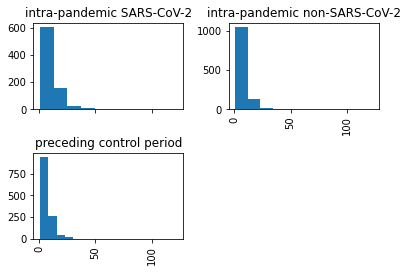

In [29]:
# Histogram comparing variables between cohorts

df.hist('pp_num_authors', by='cohort', sharex=True)


# Distribution data

In [75]:
from datetime import datetime, date
import pandas as pd

# Functions for converting tweet ID to timestamp
def find_tweet_timestamp_post_snowflake(tid):
    offset = 1288834974657
    tstamp = (tid >> 22) + offset
    return tstamp


def getTweetDateTime(tid):
    if not tid:
        return
    tstamp = find_tweet_timestamp_post_snowflake(int(tid))
    return datetime.utcfromtimestamp(tstamp / 1000)


# today_date = datetime.strftime(datetime.today(), "%Y-%m-%d")
today_date = datetime.strftime(date(2021, 1, 12), "%Y-%m-%d")
data = pd.read_csv(today_date + '_flat-file_v1s.psv', sep="|", quoting=csv.QUOTE_NONE, quotechar="", escapechar="\\")
errors = pd.read_csv("known-errors.csv")

dateColumns = [
    'date',
    'crossref_pub_date',
    'pub_date',
    'pub_date_received',
    'pub_date_accepted',
    'pub_date_entrez',
    'pub_date_pubmed',
    'pub_date_medline',
    'pub_date_revised',
    'pub_date_pmc-release'
]
data[dateColumns] = data[dateColumns].apply(
    lambda x: pd.to_datetime(x).dt.date)

pp_errors = errors[errors.type == 'preprint']['doi'].unique()
data = data[~data.doi.isin(pp_errors)]


In [79]:
import os
import glob
pp_df = pd.read_csv(os.path.join('data', 'altmetric-data', '2021-03-03_preprint_altmetric.csv'),
                    encoding='latin_1', dtype={'External Mention ID': object})
pub_df = pd.read_csv(os.path.join('data', 'altmetric-data', '2021-03-03_published_altmetric.csv'),
                     encoding='latin_1', dtype={'External Mention ID': object})


/Users/joshg/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [80]:
# Check that distribution of all preprint mentions makes sense

pp_df['Mention Type'].value_counts()


Tweet              334873
News story           7774
Blog post            1732
Facebook post         542
Policy document       152
Video                  53
Peer review            47
Patent                 40
Wikipedia page         40
F1000 post              7
Q&A post                5
Reddit post             4
Name: Mention Type, dtype: int64

In [81]:
# Check how many DOIs Altmetric has data for

msg = "Altmetric has recorded at least one mention for %s articles and %s preprints."

print(msg % (pub_df['DOI'].nunique(), pp_df['DOI'].nunique()))


Altmetric has recorded at least one mention for 6926 articles and 7460 preprints.


In [82]:
# Convert Mention Date to datetime and extract tweet datetime from tweet ID
for df in [pub_df, pp_df]:
    df['Mention Date'] = pd.to_datetime(
        df['Mention Date'],
        errors='coerce'
    )

    df['tweet_dt'] = df.apply(
        lambda x:
            getTweetDateTime(x['External Mention ID']
                             ) if x['Mention Type'] == 'Tweet' else None,
        axis=1
    )


In [83]:
alt_pub_df = pub_df.merge(data, how = 'left', left_on = 'DOI', right_on = 'published')
alt_pp_df = pp_df.merge(data, how = 'left', left_on = 'DOI', right_on = 'doi')

alt_pub_df.drop(columns = 'DOI', inplace=True)
alt_pp_df.drop(columns = 'DOI', inplace = True)

In [84]:
from datetime import date, timedelta
thirtyDaysBeforeAltmetricDataCollected = date(2021, 3, 3) + timedelta(days=-31)

thirtyDay_pub_df = alt_pub_df[
        (
            (alt_pub_df.crossref_pub_date <= thirtyDaysBeforeAltmetricDataCollected)
        ) & (
            (alt_pub_df.tweet_dt <= (alt_pub_df.crossref_pub_date + timedelta(days=30))) |
            (alt_pub_df['Mention Date'] <=
            (alt_pub_df.crossref_pub_date + timedelta(days=30)))
        )
]
thirtyDay_pp_df = alt_pp_df[
        (
            (alt_pp_df.date <= thirtyDaysBeforeAltmetricDataCollected)
        ) & (
            (alt_pp_df.tweet_dt <= (alt_pp_df.date + timedelta(days=30))) |
            (alt_pp_df['Mention Date'] <= (alt_pp_df.date + timedelta(days=30)))
        )
]

In [85]:
thirtyDay_pp_df = thirtyDay_pp_df.merge(data[data['date'] <= thirtyDaysBeforeAltmetricDataCollected][['doi', 'cohort']], on = ['doi', 'cohort'], how = 'right')
thirtyDay_pub_df = thirtyDay_pub_df.merge(data[data['crossref_pub_date'] <= thirtyDaysBeforeAltmetricDataCollected][['published', 'cohort']], on = ['published', 'cohort'], how = 'right')

thirtyDay_pp_df['altmetric_eligible'] = True
thirtyDay_pub_df['altmetric_eligible'] = True

In [86]:
thirtyDay_pp_df = thirtyDay_pp_df.merge(data[['doi', 'cohort']], on = ['doi', 'cohort'], how = 'right')
thirtyDay_pub_df = thirtyDay_pub_df.merge(data[['published', 'cohort']], on = ['published', 'cohort'], how = 'right')

In [87]:
thirtyDay_pub_df.fillna(value = {'altmetric_eligible': False}, inplace=True)

thirtyDay_pub_df['altmetric_eligible'].value_counts(dropna = False)

True    585830
Name: altmetric_eligible, dtype: int64

In [88]:
na_pubs = len(thirtyDay_pub_df[~thirtyDay_pub_df.altmetric_eligible])
na_pp = len(thirtyDay_pp_df[~thirtyDay_pp_df.altmetric_eligible])
print('There are %s publications and %s preprints which we have not yet observed 30 days of data for' % (
    na_pubs,
    na_pp
))

There are 0 publications and 0 preprints which we have not yet observed 30 days of data for


In [89]:
thirtyDay_pub_df[~thirtyDay_pub_df.altmetric_eligible].groupby('cohort').size()

Series([], dtype: int64)

In [90]:
thirtyDay_pp_df = thirtyDay_pp_df[thirtyDay_pp_df.altmetric_eligible]
thirtyDay_pub_df = thirtyDay_pub_df[thirtyDay_pub_df.altmetric_eligible]

In [91]:
thirtyDay_pp_df[['date', 'Mention Date', 'tweet_dt']]

,date,Mention Date,tweet_dt
0,2019-05-12,NaT,2019-05-22 12:53:43.704
1,2019-05-12,NaT,2019-05-12 18:43:02.613
2,2019-05-12,NaT,2019-05-12 16:12:33.572
3,2019-05-12,NaT,2019-05-12 15:47:27.201
4,2019-05-12,NaT,2019-05-12 15:47:26.939
...,...,...,...
302694,2020-11-04,NaT,2020-11-05 00:22:55.970
302695,2020-11-04,NaT,2020-11-04 23:29:59.863
302696,2020-11-04,NaT,2020-11-04 23:19:03.252
302697,2020-11-04,NaT,2020-11-04 23:13:10.576


In [92]:
thirtyDay_pp_df.groupby(['doi', 'Mention Type']).size().unstack('Mention Type').fillna(0).merge(thirtyDay_pp_df[['doi', 'cohort']].drop_duplicates(), on='doi', how='right').fillna(0)[['doi', 'cohort', 'Tweet', 'News story', 'Policy document']].groupby('cohort').quantile([0.5, 0.25, 0.75])

Tweet  News story  Policy document
cohort                                                                
intra-pandemic SARS-CoV-2     0.50   19.0         0.0              0.0
                              0.25    9.0         0.0              0.0
                              0.75   70.0         1.0              0.0
intra-pandemic non-SARS-CoV-2 0.50    7.0         0.0              0.0
                              0.25    3.0         0.0              0.0
                              0.75   17.0         0.0              0.0
preceding control period      0.50    7.5         0.0              0.0
                              0.25    4.0         0.0              0.0
                              0.75   18.0         0.0              0.0

In [93]:
thirtyDay_pub_df.groupby(['published', 'Mention Type']).size().unstack('Mention Type').fillna(0).merge(thirtyDay_pub_df[['published', 'cohort']].drop_duplicates(), on='published', how='right').fillna(0)[['published', 'cohort', 'Tweet', 'News story', 'Policy document']].groupby('cohort').quantile([0.5, 0.25, 0.75])

Tweet  News story  Policy document
cohort                                                                
intra-pandemic SARS-CoV-2     0.50   10.0         0.0              0.0
                              0.25    2.0         0.0              0.0
                              0.75   84.0         7.0              0.0
intra-pandemic non-SARS-CoV-2 0.50    7.0         0.0              0.0
                              0.25    2.0         0.0              0.0
                              0.75   20.0         0.0              0.0
preceding control period      0.50    6.0         0.0              0.0
                              0.25    1.0         0.0              0.0
                              0.75   21.0         0.0              0.0

In [94]:
print(thirtyDay_pp_df['doi'].nunique())
print(thirtyDay_pub_df['published'].nunique())

7546
7546


In [95]:
test_pp_df = thirtyDay_pp_df.groupby(['doi', 'Mention Type']).size().unstack('Mention Type').fillna(0).merge(thirtyDay_pp_df[['doi', 'cohort']].drop_duplicates(), on='doi', how='right').fillna(0)

display(test_pp_df[test_pp_df['News story'] != 0].groupby('cohort').size())
display(test_pp_df[test_pp_df['News story'] == 0].groupby('cohort').size())

display(test_pp_df[test_pp_df['Policy document']
                   != 0].groupby('cohort').size())

display(test_pp_df[test_pp_df['Policy document']
                   == 0].groupby('cohort').size())


cohort
intra-pandemic SARS-CoV-2        392
intra-pandemic non-SARS-CoV-2     14
preceding control period          21
dtype: int64

cohort
intra-pandemic SARS-CoV-2         785
intra-pandemic non-SARS-CoV-2    3589
preceding control period         2745
dtype: int64

cohort
intra-pandemic SARS-CoV-2    37
dtype: int64

cohort
intra-pandemic SARS-CoV-2        1140
intra-pandemic non-SARS-CoV-2    3603
preceding control period         2766
dtype: int64

In [96]:
test_pub_df = thirtyDay_pub_df.groupby(['published', 'Mention Type']).size().unstack('Mention Type').fillna(0).merge(thirtyDay_pub_df[['published', 'cohort']].drop_duplicates(), on='published', how='right').fillna(0)

display(test_pub_df[test_pub_df['News story'] != 0].groupby('cohort').size())
display(test_pub_df[test_pub_df['News story'] == 0].groupby('cohort').size())

display(test_pub_df[test_pub_df['Policy document'] != 0].groupby('cohort').size())
display(test_pub_df[test_pub_df['Policy document'] == 0].groupby('cohort').size())


cohort
intra-pandemic SARS-CoV-2        436
intra-pandemic non-SARS-CoV-2    491
preceding control period         350
dtype: int64

cohort
intra-pandemic SARS-CoV-2         741
intra-pandemic non-SARS-CoV-2    3112
preceding control period         2416
dtype: int64

cohort
intra-pandemic SARS-CoV-2        55
intra-pandemic non-SARS-CoV-2     1
preceding control period          1
dtype: int64

cohort
intra-pandemic SARS-CoV-2        1122
intra-pandemic non-SARS-CoV-2    3602
preceding control period         2765
dtype: int64

In [119]:
import csv
# df = data

df['doi_link'] = 'https://doi.org/' + df['doi']
df['published_link'] = 'https://doi.org/' + df['published']

SARS_mask = df.cohort == 'intra-pandemic SARS-CoV-2'

SARS_df = df[SARS_mask]

export_cols = [
    'abstract_diff_cosine_tf',
    'doi_link', 
    'published_link', 
    'pub_journal_name', 
    'scraped_abstract', 
    'pub_abstract'
]

# 25th percentile example

small_change_df = SARS_df[
    (SARS_df.abstract_diff_cosine_tf >= SARS_df['abstract_diff_cosine_tf'].quantile(0.2).item()) &
    (SARS_df.abstract_diff_cosine_tf <=
     SARS_df['abstract_diff_cosine_tf'].quantile(0.3).item())
].sample()[export_cols]

# 50th percentile example

med_change_df = SARS_df[
    (SARS_df.abstract_diff_cosine_tf >= SARS_df['abstract_diff_cosine_tf'].quantile(0.45).item()) &
    (SARS_df.abstract_diff_cosine_tf <=
     SARS_df['abstract_diff_cosine_tf'].quantile(0.55).item())
].sample()[export_cols]

# 75th percentile example

large_change_df = SARS_df[
    (SARS_df.abstract_diff_cosine_tf >= SARS_df['abstract_diff_cosine_tf'].quantile(0.7).item()) &
    (SARS_df.abstract_diff_cosine_tf <=
     SARS_df['abstract_diff_cosine_tf'].quantile(0.8).item())
].sample()[export_cols]


large_change_df.to_csv('large_sample.csv', sep='|', quoting=csv.QUOTE_NONE, quotechar="", escapechar="\\")
small_change_df.to_csv('sample_small.csv', sep = '|', quoting=csv.QUOTE_NONE, quotechar="", escapechar="\\")
med_change_df.to_csv('med_change.csv', sep = '|', quoting=csv.QUOTE_NONE, quotechar="", escapechar="\\")


In [131]:
df[df.scraped_abstract.str.contains('[A-Za-z]\.[A-Za-z]')][['doi', 'published']]

,doi,published
4,10.1101/636142,10.1016/j.nbd.2020.104737
10,10.1101/635029,10.1093/bioinformatics/btz921
15,10.1101/637132,10.1371/journal.pone.0223313
17,10.1101/636639,10.1093/bioinformatics/btz704
20,10.1101/635854,10.1128/jvi.01282-19
...,...,...
7538,10.1101/2020.10.06.20171579,10.7759/cureus.10918
7542,10.1101/2020.10.25.20219030,10.1002/eji.202049058
7543,10.1101/2020.10.26.20218636,10.1126/scitranslmed.abe4282
7544,10.1101/2020.10.25.20217141,10.3390/ijerph17249346


In [ ]:
import matplotlib.pyplot as plt

df.groupby('cohort').pub_journal_name.value_counts().plot(
    kind='barh', figsize=(30, 150))

plt.savefig('myfile.pdf', figsize=(30, 150))


In [24]:
from scipy.stats import median_test

func = median_test

metric = 'abstract_diff_cosine_tf'

significance = 0.05

comparison_dict = []

for journal in df['pub_journal_name'].unique():

    mask = df.pub_journal_name == journal
    data_frame = df[~mask].copy()

    ext_control = data_frame[data_frame.cohort ==
                             'preceding control period'][metric].tolist()
    int_control = data_frame[data_frame.cohort ==
                             'intra-pandemic non-SARS-CoV-2'][metric].tolist()
    SARS = data_frame[data_frame.cohort ==
                      'intra-pandemic SARS-CoV-2'][metric].tolist()

    int_v_ext_p = func(int_control, ext_control)[1]
    int_v_SARS_p = func(int_control, SARS)[1]
    ext_v_SARS_p = func(ext_control, SARS)[1]

    SARS_count = len(df[(df.cohort == 'intra-pandemic SARS-CoV-2')
                        & (df.pub_journal_name == journal)])
    int_count = len(df[(df.cohort == 'intra-pandemic non-SARS-CoV-2')
                       & (df.pub_journal_name == journal)])
    ext_count = len(df[(df.cohort == 'preceding control period')
                       & (df.pub_journal_name == journal)])

    comparison_dict.append({
        'comparison': 'controls',
        'p value': int_v_ext_p,
        'metric': metric,
        'journal': journal,
        'SARS count': SARS_count,
        'int count': int_count,
        'ext count': ext_count
    })

    comparison_dict.append({
        'comparison': 'internal vs. SARS',
        'p value': int_v_SARS_p,
        'metric': metric,
        'journal': journal,
        'SARS count': SARS_count,
        'int count': int_count,
        'ext count': ext_count
    })

    comparison_dict.append({
        'comparison': 'external vs. SARS',
        'p value': ext_v_SARS_p,
        'metric': metric,
        'journal': journal,
        'SARS count': SARS_count,
        'int count': int_count,
        'ext count': ext_count
    })

    # Critical values
    if int_v_ext_p <= significance:
        print("\nControls now significantly differ for %s if %s removed. Value: %s" % (
            metric, journal, int_v_ext_p))
    if int_v_SARS_p >= significance:
        print("\nInternal control vs. SARS for %s not significant if %s removed. Value: %s" % (
            metric, journal, int_v_SARS_p))
    if ext_v_SARS_p >= significance:
        print("\nExternal control vs. SARS for %s not significant if %s removed. Value: %s" % (
            metric, journal, ext_v_SARS_p))


In [27]:
import pandas as pd

comparison_df = pd.DataFrame(comparison_dict)

comparison_df.loc[comparison_df.groupby('comparison')['p value'].idxmax()]


,comparison,p value,metric,journal,SARS count,int count,ext count
9,controls,1.000000e+00,abstract_diff_cosine_tf,frontiers in neurology,1,6,3
158,external vs. SARS,1.615197e-42,abstract_diff_cosine_tf,"science (new york, n.y.)",46,19,16
157,internal vs. SARS,3.398141e-44,abstract_diff_cosine_tf,"science (new york, n.y.)",46,19,16
